## ML

In [1]:
import re
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

!pip install category_encoders
import category_encoders as ce


In [171]:
'''importation du df'''
df = pd.read_csv(r'C:\Users\Qw\Desktop\projet_gaming\vgsales_complet.csv')



'''comparer les nom des jeux entre fichier de laurent et vg_sales (metacritic vs vg_sales)'''
samegame=[]
for i, j in zip(df['Name'],df['gamename']):
    if i in j or j in i:
        samegame.append(1)
    else:
        samegame.append(0)
df['same_game']=samegame 




'''recupération des données : '''
    # extraire les données de la colonne userscorewrap pour corriger les erreurs de
    #la colonne ratings et nb_votes
y=[]
for i in df['userscorewrap']:
    x = re.findall(r'[0-9\.0-9]+',i)
    y.append(x)
df['userscorewrap2']=y
    # remplacer les listes vides ou avec une seul valeur par [0,0] afin 
    # d'éviter l'erreur de "length..."
for i in df['userscorewrap2']:
    if i==[]:
        i.append(0)
        i.append(0)
    if len(i)==1:
        i.clear()
        i.append(0)
        i.append(0)
    # extraire les données de la colonne metascorewrap pour corriger les erreurs de
    #la colonne metascore et nb_critic
n=[]
for i in df['metascorewrap']:
    x = re.findall(r'[0-9\.0-9]+',i)
    n.append(x)
df['metascorewrap2']=n
    # remplacer les listes vides ou avec une seul valeur par [0,0] afin d'éviter l'erreur de "length..."
for i in df['metascorewrap2']:
    if i==[]:
        i.append(0)
        i.append(0)
    if len(i)==1:
        i.clear()
        i.append(0)
        i.append(0)
    # recuperer les données de la colonnes metascorewrap2 et userscorewrap2
x=[]
y=[]
for i in df['userscorewrap2']:
    x.append(i[0])
    y.append(i[1])
df['ratings']=x
df['nb_votes']=y

x=[]
y=[]
for i in df['metascorewrap2']:
    x.append(i[0])
    y.append(i[1])
df['metascore']=x
df['nb_critic']=y

    # recuperer série (si série donc =1 sinon 0)
serie=[]
def extract_series(x): 
    r = re.compile(r"Series:.*\n") 
    result=r.findall(x)
    if result!=[]:
        y=result[0]
        return(y[8:-2]) 
    else:
        return('0')
for i in df['description']:
    serie.append(extract_series(i))
df['serie']=serie
df['serie']=df['serie'].apply(lambda x: '1' if x!='0' else x)
df['serie']=df['serie'].astype(int)

    # recuperer Awards (si awards donc =1 sinon 0)
Awards=[]
def extract_awards(x): 
    r = re.compile(r"Awards:.*\n") 
    result=r.findall(x)
    if result!=[]:
        y=result[0]
        return(y[8:-1])                
    else:
        return('0')
for i in df['description']:
    Awards.append(extract_awards(i))
df['Awards']=Awards
df['Awards']=df['Awards'].apply(lambda x: '1' if x!='0' else x)
df['Awards']=df['Awards'].astype(int)

    # recuperer Like_Percent
Like_Percent =[]
def extract_percentage(x):
    r = re.compile(r"\n\d+% liked this video game")
    result=r.findall(x)
    if result!=[]:
        y=result[0] 
        return(y[1:3]) 
    else:
        return('0')
for i in df['description']:
    Like_Percent.append(extract_percentage(i))
df['Like_Percent']=Like_Percent
df['Like_Percent']=df['Like_Percent'].str.replace(r'%','').astype(int)
z=[]
for i in df['Like_Percent']:
    z.append(i/100)
df['Like_Percent']=z



'''supprimer les jeux non compatible avec vg_salles'''
df.drop(df[df['same_game']==0].index, inplace=True)



'''nettoyage : '''
    # remplacer les nan de la colonne year par 0 et la convertir en int
df['Year']=df['Year'].replace(np.nan, 0)
df['Year']=df['Year'].astype(int)
    # remplacer les nan de la colonne Publisher par not found
df['Publisher']=df['Publisher'].replace(np.nan, 'not found')
    # convertir les types des colonnes:
df['ratings']=df['ratings'].astype(float)
df['nb_votes']=df['nb_votes'].astype(int)
df['metascore']=df['metascore'].astype(int)
df['nb_critic']=df['nb_critic'].astype(int)


        
'''supprimer les colonnes dont on a plus besoin:'''
df.drop(['top','metascorewrap','userscorewrap','nbvotes','nbratings','description',
        'gamename','same_game','userscorewrap2','metascorewrap2','developper'], axis=1,
        inplace=True)



'''reorganisation df '''
df = df[['Rank', 'Name', 'Genre', 'Year','Publisher','Platform','NA_Sales',
      'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales','ratings','nb_votes', 'metascore'
         ,'nb_critic','serie','Like_Percent']] 


'''renomer les colonnes'''
df = df.rename(columns = {'ratings':'userNote','nb_votes':'userNbVote'
                          ,'metascore':'metaNote','nb_critic':'metaNbVote'})


# quantiles (1 = les jeux mauvais...)
df['metaNoteQ']=pd.cut(df['metaNote'], bins=[0,25,50,75,100], labels=[1,2,3,4])
df['metaNoteQ']=df['metaNoteQ'].fillna(1)
df['metaNoteQ']=df['metaNoteQ'].astype(int)


df.head()

,Rank,Name,Genre,Year,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,userNote,userNbVote,metaNote,metaNbVote,serie,Like_Percent,metaNoteQ
0,1,Wii Sports,Sports,2006,Nintendo,Wii,41.49,29.02,3.77,8.46,82.74,8.1,453,76,51,1,0.96,4
1,2,Super Mario Bros.,Platform,1985,Nintendo,NES,29.08,3.58,6.81,0.77,40.24,8.5,98,84,14,1,0.92,4
2,3,Mario Kart Wii,Racing,2008,Nintendo,Wii,15.85,12.88,3.79,3.31,35.82,8.4,1047,82,73,0,0.96,4
3,4,Wii Sports Resort,Sports,2009,Nintendo,Wii,15.75,11.01,3.28,2.96,33.00,8.2,293,80,73,1,0.97,4
5,6,Tetris,Puzzle,1989,Nintendo,GB,23.20,2.26,4.22,0.58,30.26,8.2,258,83,27,0,0.00,4


In [172]:
new_df = df.drop(['Rank','Name'],axis=1)
new_df.head()

,Genre,Year,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,userNote,userNbVote,metaNote,metaNbVote,serie,Like_Percent,metaNoteQ
0,Sports,2006,Nintendo,Wii,41.49,29.02,3.77,8.46,82.74,8.1,453,76,51,1,0.96,4
1,Platform,1985,Nintendo,NES,29.08,3.58,6.81,0.77,40.24,8.5,98,84,14,1,0.92,4
2,Racing,2008,Nintendo,Wii,15.85,12.88,3.79,3.31,35.82,8.4,1047,82,73,0,0.96,4
3,Sports,2009,Nintendo,Wii,15.75,11.01,3.28,2.96,33.00,8.2,293,80,73,1,0.97,4
5,Puzzle,1989,Nintendo,GB,23.20,2.26,4.22,0.58,30.26,8.2,258,83,27,0,0.00,4


<AxesSubplot:>

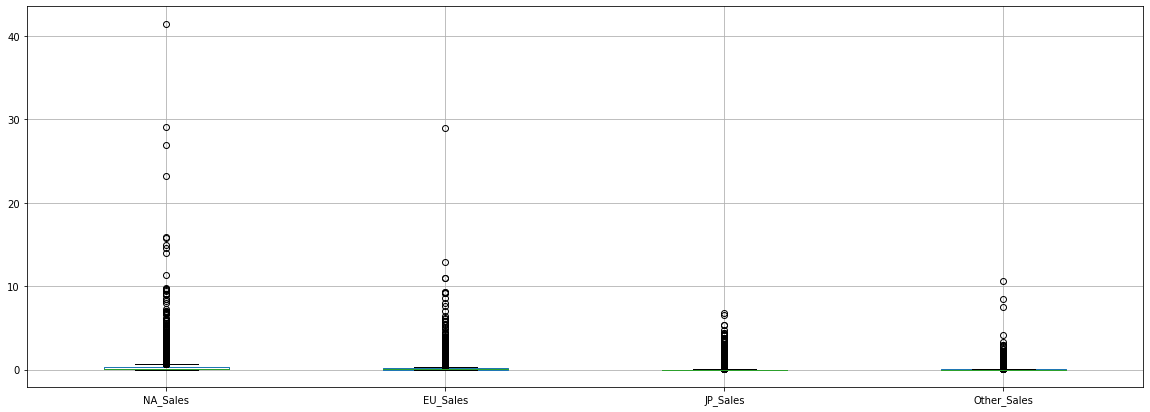

In [173]:
# les valeurs aberrantes new_df
new_df.boxplot(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], figsize=(20,7))

In [174]:
'''encoding la colonne Publisher'''
   #solution1: OrdinalEncoder ()
ord_enc = ce.OrdinalEncoder()
new_df[["Genre","Publisher", "Platform"]] = ord_enc.fit_transform(new_df[["Genre",
                                                                            "Publisher", 
                                                                            "Platform"]])
new_df
#new_df2['Genre_encod']=ord_enc.fit_transform(new_df2['Genre'])
#new_df2['Publisher_encod']=ord_enc.fit_transform(new_df2['Publisher'])
#new_df2['Platform_encod']=ord_enc.fit_transform(new_df2['Platform'])


   #solution2: TargetEncoder
#target_encoder = ce.TargetEncoder()
#new_df1['target_encoding'] = target_encoder.fit_transform(new_df1['Publisher'], new_df1['Global_Sales'])
#new_df

   #solution3: Label Encoding (pas recommandé pour les features par contre on peut l'utiliser pour 
#encoder la variable cible)
#new_df2['Publisher']= new_df2['Publisher'].astype('category')
#new_df2['target_encoding']= new_df2['Publisher'].cat.codes
#new_df2.head()



,Genre,Year,Publisher,Platform,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,userNote,userNbVote,metaNote,metaNbVote,serie,Like_Percent,metaNoteQ
0,1,2006,1,1,41.49,29.02,3.77,8.46,82.74,8.1,453,76,51,1,0.96,4
1,2,1985,1,2,29.08,3.58,6.81,0.77,40.24,8.5,98,84,14,1,0.92,4
2,3,2008,1,1,15.85,12.88,3.79,3.31,35.82,8.4,1047,82,73,0,0.96,4
3,1,2009,1,1,15.75,11.01,3.28,2.96,33.00,8.2,293,80,73,1,0.97,4
5,4,1989,1,3,23.20,2.26,4.22,0.58,30.26,8.2,258,83,27,0,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,11,2004,6,14,0.01,0.00,0.00,0.00,0.01,0.0,0,82,36,1,0.91,4
16592,7,2008,134,4,0.01,0.00,0.00,0.00,0.01,0.0,0,1,3,0,0.00,1
16594,6,2003,47,17,0.01,0.00,0.00,0.00,0.01,7.8,9,50,19,0,0.86,2
16595,3,2008,5,7,0.00,0.00,0.00,0.00,0.01,5.6,5,29,4,0,0.94,2


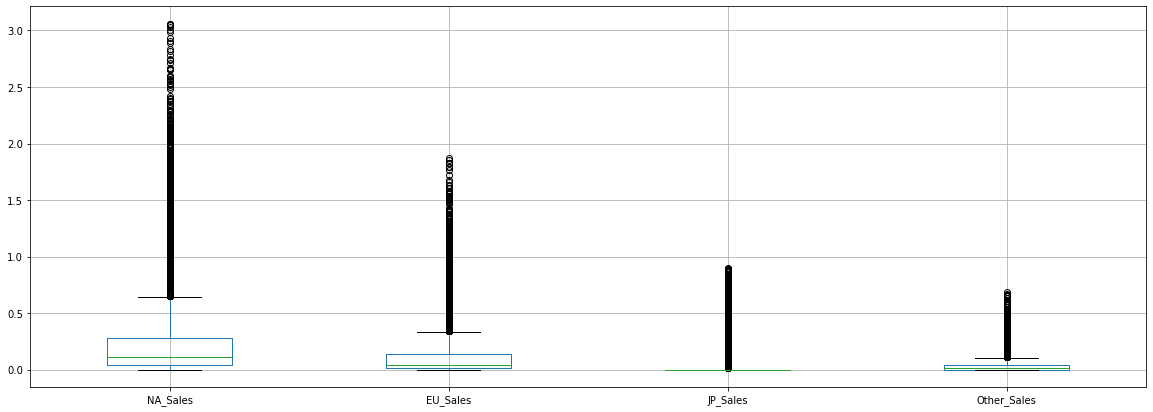

In [176]:
#supprimer les valeurs aberrantes
from scipy import stats
new_df2=new_df[(np.abs(stats.zscore(new_df)) < 3).all(axis=1)]

# verification des valeures aberrantes new_df2
new_df2.boxplot(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], figsize=(20,7));

In [177]:
'''label + target'''
data_NA =new_df2.drop(['NA_Sales'],axis=1)
target_NA=new_df2['NA_Sales']

data_EU =new_df2.drop(['EU_Sales'],axis=1)
target_EU=new_df2['EU_Sales']

data_JP =new_df2.drop(['JP_Sales'],axis=1)
target_JP=new_df2['JP_Sales']

data_GL =new_df2.drop(['Global_Sales'],axis=1)
target_GL=new_df2['Global_Sales']

              valeur_estimee
intercept       1.707864e-02
Genre           1.811746e-05
Year           -8.104430e-06
Publisher       2.437346e-07
Platform       -3.800505e-06
EU_Sales        9.999132e-01
JP_Sales        1.000847e+00
Other_Sales     9.984418e-01
Global_Sales    9.948560e-01
userNote       -3.671987e-05
userNbVote     -2.764158e-07
metaNote        1.821647e-05
metaNbVote      5.409135e-06
serie          -1.716119e-04
Like_Percent   -1.065758e-04
metaNoteQ      -4.243991e-04
le coeficient de determination sur train (R²) 0.9999181235369079
le coeficient de determination sur train (CV) 0.9999174875793326
le coeficient de determination sur test (R²) 0.9999186813784297
le coeficient de determination sur test (CV) 0.9999154951137246


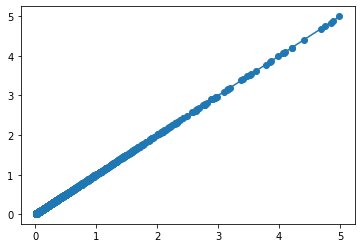

In [178]:
'''modele linear Regression ==> data_NA'''
#prepocessing

# Train + test
X_train, X_test, y_train, y_test=train_test_split(data_GL,target_GL, test_size=0.2)

# Linear Regrassion
lr = LinearRegression()
lr.fit(X_train, y_train)

# intercept_ et coef_ (ax+b)
coef=list(lr.coef_)
coef.insert(0,lr.intercept_)
feat=list(data_NA.columns)
feat.insert(0,'intercept')
print(pd.DataFrame({'valeur_estimee':coef}, index=feat))

#performance
print('le coeficient de determination sur train (R²)', lr.score(X_train,y_train))
print('le coeficient de determination sur train (CV)', cross_val_score(lr,X_train,y_train).mean())
print('le coeficient de determination sur test (R²)', lr.score(X_test,y_test))
print('le coeficient de determination sur test (CV)', cross_val_score(lr,X_test,y_test).mean())

#predict
pred_test = lr.predict(X_test)
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(),y_test.max()),(y_test.min(),y_test.max()))

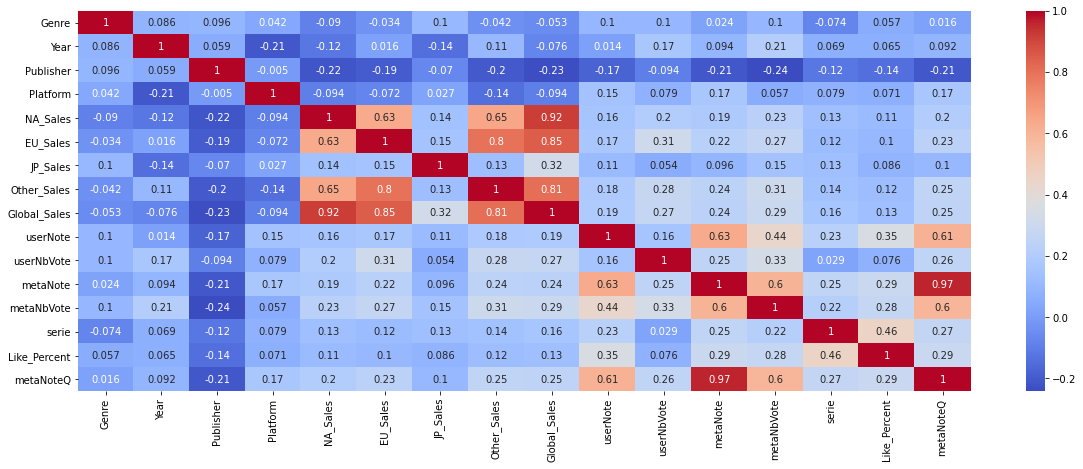

In [179]:
plt.figure(figsize=(20,7))
sns.heatmap(new_df2.corr(),annot=True,cmap='coolwarm');